In [1]:
import os

In [2]:
%ls

annotations/
annotations.tar.gz
basic_cat_dog_cnn_model.h5
cat_dog_classification_with_data_augmentation.ipynb
cnn_for_cats_dogs_classification.ipynb
data_augmentation_sample.ipynb
dataprepration_for_cnn.ipynb
feature_extraction.ipynb
feature_extraction_with_data_augmention_to_fight_overfitting.ipynb
first_hand.ipynb
images/
image_segmentation.ipynb
images.tar.gz


In [3]:
input_dir = './images/'
target_dir = './annotations/trimaps'

In [4]:
input_image_list = sorted([os.path.join(input_dir, file) for file in os.listdir(input_dir) if file.endswith('.jpg')])

In [5]:
input_image_list[0]

'./images/Abyssinian_1.jpg'

In [6]:
target_image_list = sorted([os.path.join(target_dir, file) for file in os.listdir(target_dir) if file.endswith('.png') and not file.startswith('.')])

In [7]:
import matplotlib.pyplot as plt

(0.0, 1.0, 0.0, 1.0)

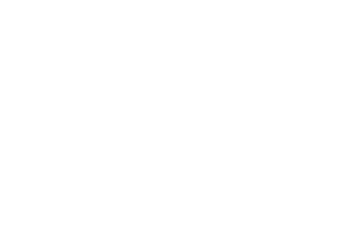

In [8]:
plt.axis("off")

In [9]:
from keras.utils import load_img, img_to_array

2024-07-24 18:07:46.573953: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 18:07:47.097353: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-24 18:07:47.097421: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-07-24 18:07:47.165543: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-24 18:07:48.188544: W tensorflow/stream_executor/platform/de

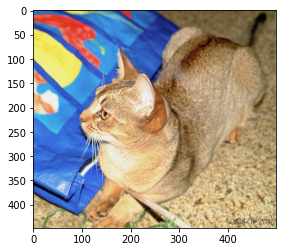

In [10]:
plt.imshow(load_img(input_image_list[9]))

In [11]:
def display_target(target_array):
    normalized_array = (target_array.astype('uint8') - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

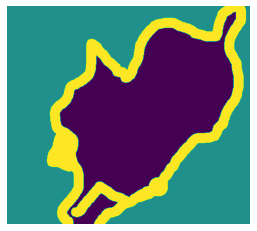

In [12]:
img = img_to_array(load_img(target_image_list[9], color_mode = 'grayscale'))
display_target(img)

In [13]:
seed = 1337

In [14]:
import numpy as np
import random

In [15]:
img_size = (200, 200)
num_img = len(input_image_list)

In [16]:
random.Random(seed).shuffle(input_image_list)
random.Random(seed).shuffle(target_image_list)

In [17]:
def path_to_input_image(path):
    img = img_to_array(load_img(path, target_size = img_size))
    return img
    

In [18]:
def path_to_target_img(path):
    img = img_to_array(load_img(path, target_size = img_size, color_mode = 'grayscale'))
    img = img.astype('uint8') - 1
    return img

In [19]:
input_images = np.zeros( shape = (num_img, ) + img_size + (3, ), dtype = 'float32')
target_images = np.zeros(shape = (num_img,) + img_size + (1, ), dtype = 'uint8')

In [20]:
print(input_images.shape)
print(target_images.shape)

(7390, 200, 200, 3)
(7390, 200, 200, 1)


In [21]:
for i in range(num_img):
    input_images[i] = path_to_input_image(input_image_list[i])
    target_images[i] = path_to_target_img(target_image_list[i])

In [22]:
num_val_samples = 1000

In [23]:
train_input_samples = input_images[: -num_val_samples]
train_target_samples = target_images[: -num_val_samples]

In [24]:
val_input_samples = input_images[-num_val_samples: ]
val_target_samples = target_images[-num_val_samples: ]

In [25]:
print("[*] Traing input shape {} training target samples {}".format(train_input_samples.shape, train_target_samples.shape))

[*] Traing input shape (6390, 200, 200, 3) training target samples (6390, 200, 200, 1)


In [26]:
print("[*] Validation input shape {} validation target samples {}".format(val_input_samples.shape, val_target_samples.shape))

[*] Validation input shape (1000, 200, 200, 3) validation target samples (1000, 200, 200, 1)


In [27]:
from keras import layers, models, Input
import keras

In [28]:
def get_model(img_size, num_class):
    input_layer = Input(shape = img_size + (3,))
    x = layers.Rescaling(1./255)(input_layer)
    x = layers.Conv2D(64, 3, strides = 2, padding = "same", activation = "relu")(x)
    x = layers.Conv2D(64, 3, padding = "same", activation = "relu")(x)
    x = layers.Conv2D(128, 3, strides = 2, padding = "same", activation = "relu")(x)
    x = layers.Conv2D(128, 3, padding = "same", activation = "relu")(x)
    x = layers.Conv2D(256, 3, strides = 2, padding = "same", activation = "relu")(x)
    x = layers.Conv2D(256, 3, padding = "same", activation = "relu")(x)
    
    x = layers.Conv2DTranspose(256, 3, padding = "same", activation = "relu")(x)
    x = layers.Conv2DTranspose(256, 3, strides = 2, padding = "same", activation = "relu")(x)
    x = layers.Conv2DTranspose(128, 3, padding = "same", activation = "relu")(x)
    x = layers.Conv2DTranspose(128, 3, strides = 2, padding = "same", activation = "relu")(x)
    x = layers.Conv2DTranspose(64, 3, padding = "same", activation = "relu")(x)
    x = layers.Conv2DTranspose(64, 3, strides = 2, padding = "same", activation = "relu")(x)
    
    outputs = layers.Conv2D(num_class, 3, padding = "same", activation = "softmax")(x)
    
    model = models.Model(input_layer, outputs)
    
    return model

In [29]:
model = get_model(img_size, 3)
model.compile(
    optimizer = 'rmsprop',
    loss = 'sparse_categorical_crossentropy'
)

2024-07-24 18:08:19.742534: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-07-24 18:08:19.742843: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-07-24 18:08:19.742868: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mukesh-ThinkPad-E14): /proc/driver/nvidia/version does not exist
2024-07-24 18:08:19.743417: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [31]:
callback_list = [
    keras.callbacks.ModelCheckpoint("segmentation_model.h5", save_best_only = True, metrics = 'val_loss')
]

In [ ]:
history = model.fit(
    train_input_samples,
    train_target_samples,
    epochs = 50,
    callbacks=callback_list,
    batch_size = 64,
    validation_data = (val_input_samples, val_target_samples)
)